# HBM - validation

## Data and imports

In [1]:
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm_notebook
import os, datetime

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.animation as animation

import IPython
from IPython.display import display, HTML

import sys
sys.path.append("../../models/bcts")

from model.model import *
from model.model_presets import BASELINE_MODEL, HIGH_MOVEMENT

In [3]:
def derive_mu_sigma_lognormal(mean, variance):
    sigma = np.sqrt(np.log(variance/(mean**2) + 1))
    mu    = np.log(mean) - .5*(sigma**2)
    return mu, sigma

NEW_BASELINE_MODEL = {
    "k" : 3,
    "timestep" : (2/24),
    "movement_dist" : lambda : np.random.lognormal(*derive_mu_sigma_lognormal(1, .001)),
    "sigma_h_arr" : np.array([19, 19, 19]),
    "sigma_v_arr" : np.array([.5, .5, .5]),
    "K_v_arr" : \
    np.array([3000, 8800, 9700]),
    # np.array([2750, 8250, 9625]),
    # np.array([2750, 8100, 8900]),
    # np.array([5000, 2500, 2000]),
    # np.array([1800, 2700, 6700]),
    # np.array([600, 660, 1090]),
    # np.array([11_000, 13_000, 42_000]),
    # np.array([50_000, 6_000, 5_400]),
    # np.array([1_000, 3_000, 5_000]),
    # np.array([10_000, 20_000, 50_000]),
    "patch_densities" : np.array([.85, .08, .07]),
    "psi_v_arr" : np.array([.3, .3, .3]), # TESTING THIS AS IS
    "beta_hv_arr" : np.array([.33, .33, .33]),
    "beta_vh_arr" : np.array([.33, .33, .33]),
    "nu_v_arr" : np.array([.1, .1, .1]),
    "mu_v_arr" : np.array([1/14, 1/14, 1/14]),
    "num_households" : 2_351,
    "edge_prob" : .03,
    "num_agents" : 10_053,
    "initial_infect_proportion" : .005,
    "patch_init_infect_vector_prop_arr" : [.0, .0, .0],
    # "patch_init_infect_vector_prop_arr" : [.0555, .0286, .011],
    "nu_h_dist" : lambda : np.random.lognormal(*derive_mu_sigma_lognormal(1/5, .001)),
    "mu_h_dist" : lambda : np.random.lognormal(*derive_mu_sigma_lognormal(1/6, .001)),
    "total_time" : 200,
    "mosquito_timestep" : .005,
    "prob_adopt_itn": .0,
    "stay_home_chance": .0,
    "high_severity": True,
    "high_benefits": True,
    "high_barriers": False,
}

## Running HBM

In [4]:
m = BaselineModel(**NEW_BASELINE_MODEL)
data, _ = m.run(with_progress=True)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2400/2400 [02:03<00:00, 19.41it/s]


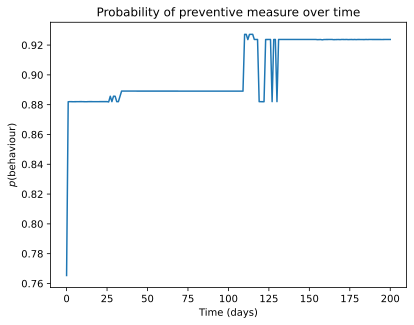

In [5]:
plt.plot(data['prob_values'][data['prob_values'].nonzero()])

# plt.axhline(0.7289972899728997, ls='dashed', c='black')
# plt.axhline(0.5877478665952096, ls='dashed', c='black')

plt.xlabel("Time (days)")
plt.ylabel(r"$p(\text{behaviour})$")
plt.title("Probability of preventive measure over time")
plt.show()

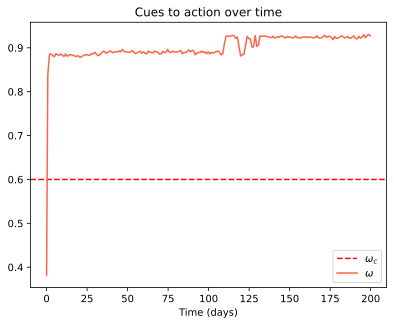

In [6]:
p_inds = data["prob_values"].nonzero()
t = np.array(data['time'])

# plt.plot(t[p_inds], data["used_itn"][p_inds]/10_053, color='black', label=r"ITN use rate")
# plt.plot(t[p_inds], data["prob_values"][p_inds], color='black', label=r"$p(\text{behaviour})$")
# plt.plot(t[p_inds], data["chi"][p_inds], color='steelblue', label=r"$\chi$")
# plt.axhline(.5, linestyle='dashed', c='steelblue', label=r"$\chi_c$")
# plt.axhline(.73)
# plt.axhline(.587)

plt.axhline(m.agents[0].hbm.omega, linestyle='dashed', c='red', label=r"$\omega_c$")
plt.plot(t[p_inds], data["omega"][p_inds], color="tomato", label=r"$\omega$")

plt.legend()
plt.xlabel("Time (days)")
plt.title("Cues to action over time")
plt.show()

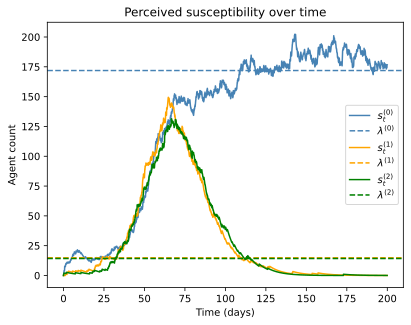

In [8]:
delta_val = .99#m._hbm_delta_val

for patch_id, c in enumerate(['steelblue', 'orange', 'green']):
    c_ts = [np.sum([(delta_val**i)*(m.c_t[patch_id][j-i-1]) for i in range(j)]) for j in range(m.tick_counter)]
    plt.plot(data['time'], c_ts, color=c, label=r"$s_t^{({"+str(patch_id)+r"})}$")
    plt.axhline(m.s_stars[patch_id], color=c, linestyle='dashed', label=r"$\lambda^{({"+str(patch_id)+r"})}$")
    
# plt.axhline(m.agents[0].hbm.s_star, c='black', linestyle='dashed', label=r"$\lambda$")
plt.xlabel("Time (days)")
plt.ylabel("Agent count")

plt.legend()
plt.title("Perceived susceptibility over time")
plt.show()

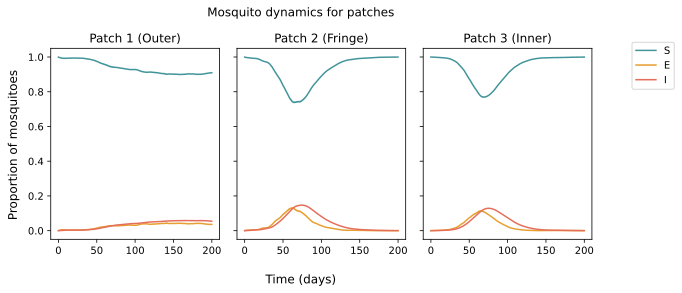

In [9]:
names = ["Patch 1 (Outer)", "Patch 2 (Fringe)", "Patch 3 (Inner)"]
labels= ["S", "E", "I"]

fig, axs = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(8.5,4))
cur_name = 0

for i, col in enumerate(axs):
    for j, c, l in zip(range(len(axs)), ["#41949A", "#e79f31", "#E56E5A", "#7384BB"], labels):
        if i == 0:
            axs[i].plot(np.arange(0, m.total_time, m.timestep), data["patch_sei"][i].T[j]/m.K_v_arr[i], color=c, label=l)
        else:
            axs[i].plot(np.arange(0, m.total_time, m.timestep), data["patch_sei"][i].T[j]/m.K_v_arr[i], color=c)
#     for (i, color, args) in zip(range(3), range(1,4), ["steelblue", "green", "red"], [{}, {"marker": "o", "markevery": 15}, {"linestyle": "dashed"}]):
#         sns.kdeplot(peak_infection_times[temp_names[cur_name]][patch], ax=col, bw_adjust=.5, color=color, label=f"Patch {name}" if cur_name == 0 else None, **args)

#     col.set_xlim(0,200)
    
#     col.set_xlabel("")
#     col.set_ylabel("")

    col.set_title(names[i])
    
#     cur_name += 1

fig.suptitle("Mosquito dynamics for patches")

fig.supxlabel("Time (days)")
fig.supylabel("Proportion of mosquitoes")
fig.legend(bbox_to_anchor=[1.12, 0.875])
fig.tight_layout()
plt.savefig("img/v3_3_0itn_mosq", dpi=330)

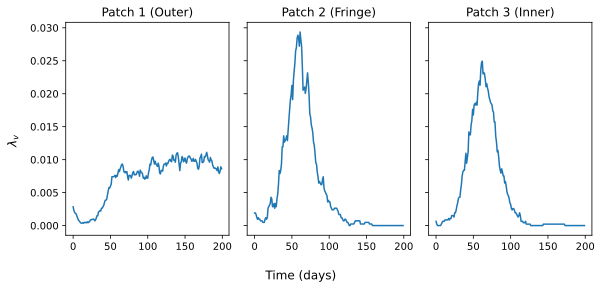

In [10]:
fig, axs = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(8.5,4))
cur_name = 0

for i, col in enumerate(axs):
    axs[i].plot(data['time'][::12], data["lambda_v"][i][::12])
    col.set_title(names[i])

fig.supxlabel(r"Time (days)")
fig.supylabel(r"$\lambda_v$")
fig.tight_layout()
plt.savefig("img/lambda_v_patch", dpi=330)

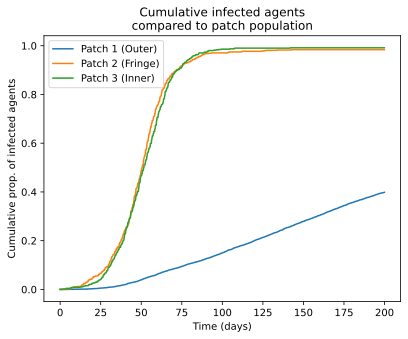

In [11]:
df = pd.DataFrame(data["infection_records"])
patch_pops = [np.sum([a.node.patch_id == j for a in m.agents]) for j in range(3)]

for i in range(3):
    vals = np.zeros(m.tick_counter)
    infs = df[df.home_patch == i].groupby(by=['time']).size().reset_index()
    vals[infs.time] = infs.iloc[:, 1]
    
    plt.plot(np.arange(0, m.total_time, m.timestep),
             vals.cumsum()/patch_pops[i],
            label=names[i])

plt.title("Cumulative infected agents\ncompared to patch population")
plt.xlabel("Time (days)")
plt.ylabel("Cumulative prop. of infected agents")
plt.legend()
plt.savefig("img/patch_infections_t", dpi=330)

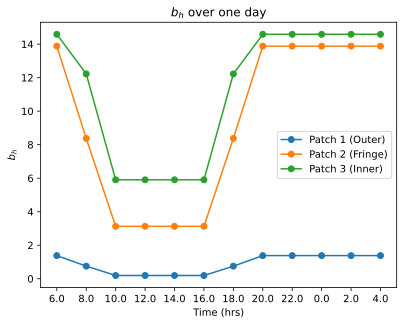

In [12]:
df = pd.DataFrame(data["patch_values"])
tick_start = 27 * 1
t = np.arange(start_time:=(tick_start*m.timestep*24 % 24), # time in simulation (hrs)
              start_time+24, # 1 day window
              step=24*m.timestep)

for i in range(3):
    plt.plot(t,
             df[df.patch_id == i].b_h.reset_index(drop=True)[tick_start:tick_start+int(1/m.timestep)],
            'o-',
            label=names[i]) #TODO: plot actual time, compare patches.
plt.xticks(t, labels=t % 24)

plt.title(r"$b_h$ over one day")
plt.xlabel("Time (hrs)")
plt.ylabel(r"$b_h$")
plt.legend()
plt.savefig("img/b_h_patch", dpi=330)

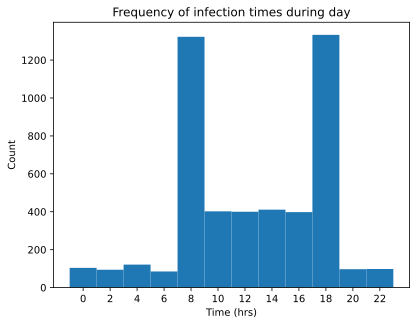

In [13]:
df = pd.DataFrame(data["infection_records"])

# plt.hist((df.time * m.timestep * 24) % 24, bins=12)
plt.bar(np.arange(0,24,2), np.unique(((df.time * m.timestep * 24) % 24).map(np.round), return_counts=True)[1], width=2)
plt.xticks(np.arange(0,24,2))
plt.title("Frequency of infection times during day")
plt.xlabel("Time (hrs)")
plt.ylabel("Count")

plt.savefig("img/infection_times", dpi=330)

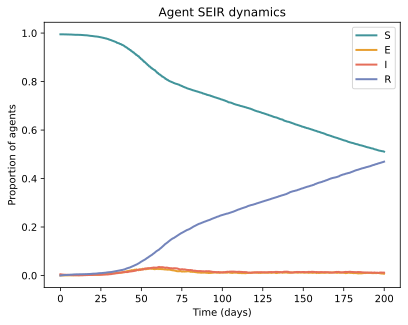

In [14]:
for j, c in zip(range(4), ["#41949A", "#e79f31", "#E56E5A", "#7384BB"]):
    plt.plot(np.arange(0, m.total_time, m.timestep), np.sum(data["agent_disease_counts"],axis=0)[j]/m.num_agents, color=c, lw=2, label=(labels+["R"])[j])
plt.xlabel("Time (days)")
plt.ylabel("Proportion of agents")
plt.title("Agent SEIR dynamics")
plt.legend()
# plt.xlim(85,100)
plt.savefig("img/v3_3_0itn_agent",dpi=330)

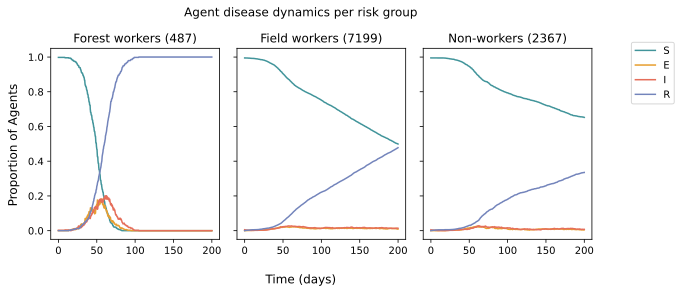

In [15]:
amts = (np.sum([a.forest_worker for a in m.agents]),
        np.sum([a.field_worker for a in m.agents]),
        np.sum([not (a.forest_worker or a.field_worker) for a in m.agents]))
names = ["Forest workers", "Field workers", "Non-workers"]
labels= ["S", "E", "I", "R"]

fig, axs = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(8.5,4))
cur_name = 0

for i, col in enumerate(axs):
    for j, c, l in zip(range(len(labels)), ["#41949A", "#e79f31", "#E56E5A", "#7384BB"], labels):
        if i == 0:
            axs[i].plot(np.arange(0, m.total_time, m.timestep), data["agent_disease_counts"][i][j]/amts[i], color=c, label=l)
        else:
            axs[i].plot(np.arange(0, m.total_time, m.timestep), data["agent_disease_counts"][i][j]/amts[i], color=c)
    col.set_title(names[i] + f" ({amts[i]})")
    
fig.suptitle("Agent disease dynamics per risk group")

fig.supxlabel("Time (days)")
fig.supylabel("Proportion of Agents")
fig.legend(bbox_to_anchor=[1.12, 0.875])
fig.tight_layout()
plt.savefig("img/v3_3_0itn_agent_risk_groups", dpi=330)

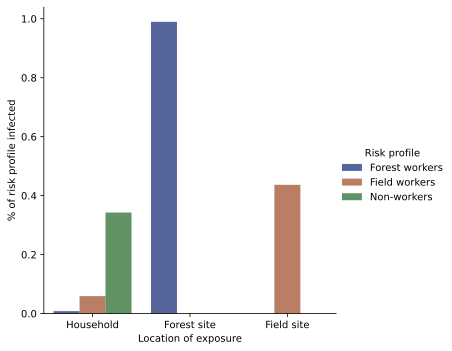

In [16]:
df = pd.DataFrame(data["infection_records"]).groupby(by=["worker_type", "activity_id"]).size().reset_index(name="num")
df["num"] = df.num.map(float)

for i, _ in df.iterrows():
    df.iloc[i, 2] /= amts[(df.iloc[i,0])]

df["worker_type"] = df.worker_type.map({0: "Forest workers", 1: "Field workers", 2: "Non-workers"})
df["activity_id"] = df.activity_id.map({0: "Household", 1: "Forest site", 2: "Field site"})

g = sns.catplot(
    data=df,
    kind="bar",
    x="activity_id",
    y="num",
    hue="worker_type",
    # errorbar="sd",
    palette="dark",
    alpha=.7,
)
# g.despine(left=True)
g.set_axis_labels("Location of exposure", "% of risk profile infected")
g.legend.set_title("Risk profile")
plt.show()

### Old graphs

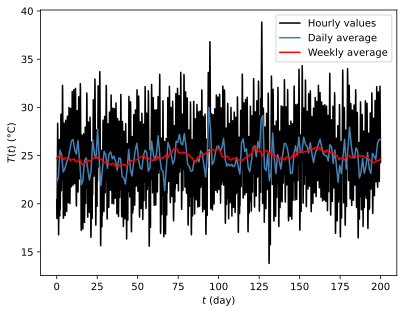

In [5]:
def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

a = data["temperature"]
t = np.arange(0,200,m.timestep)

plt.plot(t,a,c='black',label="Hourly values")

avgs1 = moving_average(a,24)
avgs2 = moving_average(a,24*7)
plt.plot(np.linspace(0,200,len(avgs1)),avgs1,label="Daily average",color='steelblue')
plt.plot(np.linspace(0,200,len(avgs2)),avgs2,label="Weekly average",color='red')
plt.legend()
plt.ylabel(r"$T(t)$ (°C)")
plt.xlabel(r"$t$ (day)")
# plt.plot(moving_average(a,12))
plt.show()

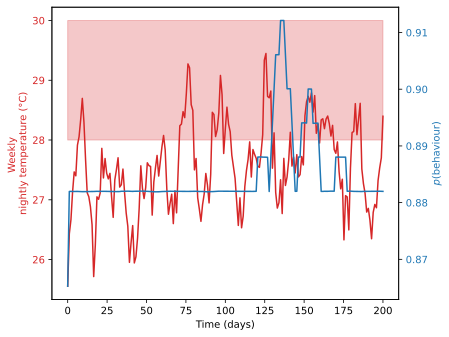

In [8]:
fig, ax1 = plt.subplots()

avgs1 = moving_average(data['temperature'][p_inds], 7)
avgs2 = moving_average(data['prob_values'][p_inds], 7)

color = 'tab:red'
ax1.set_xlabel('Time (days)')
ax1.set_ylabel('Weekly \nnightly temperature (°C)', color=color)
# ax1.axhline(29, linestyle='dashed', color=color)
# ax1.plot(t[p_inds], data['temperature'][p_inds], color=color)
ax1.fill_between([0, m.total_time], [28, 28], [max(30,avgs1.max()), max(30,avgs1.max())], alpha=.25, color=color)
ax1.plot(np.linspace(0,m.total_time,len(avgs1)), avgs1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel(r'$p(\text{behaviour})$', color=color)  # we already handled the x-label with ax1
# ax2.plot(t[p_inds], data['prob_values'][p_inds], color=color)
ax2.plot(np.linspace(0,m.total_time,len(avgs2)), avgs2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [9]:
np.corrcoef(data['temperature'][p_inds].T, data['prob_values'][p_inds].T)

array([[1.        , 0.18427999],
       [0.18427999, 1.        ]])

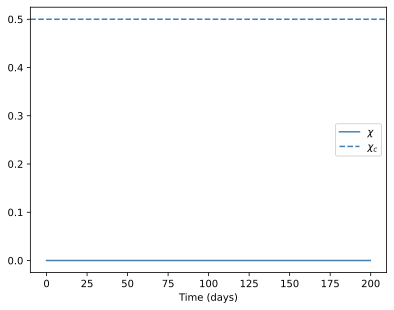

In [11]:
plt.plot(t[p_inds], data["chi"][p_inds], color='steelblue', label=r"$\chi$")
plt.axhline(m.agents[0].hbm.chi, linestyle='dashed', c='steelblue', label=r"$\chi_c$")

plt.legend()
plt.xlabel("Time (days)")
plt.show()

In [12]:
np.mean([len(m.agent_network[i]) for i in range(m.num_agents)])

228.22799164428528

(array([2222., 1335., 1818., 1728., 1431., 1240.,  193.,   35.,   38.,
          13.]),
 array([ 0. ,  1.2,  2.4,  3.6,  4.8,  6. ,  7.2,  8.4,  9.6, 10.8, 12. ]),
 <BarContainer object of 10 artists>)

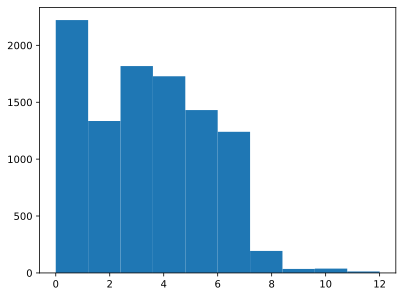

In [13]:
plt.hist([np.sum([m.agents[j].state == DiseaseState.INFECTED for j in m.agent_network[i]]) for i in range(m.num_agents)])

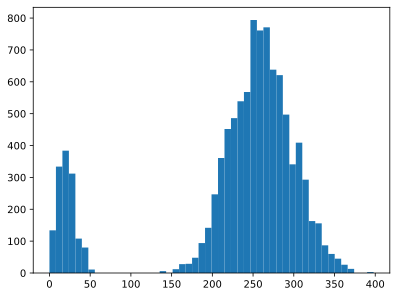

In [14]:
plt.hist([len(m.agent_network[i]) for i in range(m.num_agents)],bins=50)
plt.show()

In [17]:
ORs = np.array([1,     # constant
                1.8,   # susceptibility
                2.78,  # severity
                1.0,   # benefits
                .53,   # barriers
                2.69   # cues to action
                ])
inds = np.array([1, 1, 1, 0, 0, 1])
np.prod(ORs**inds)/(1+np.prod(ORs**inds))

0.9308473413568858

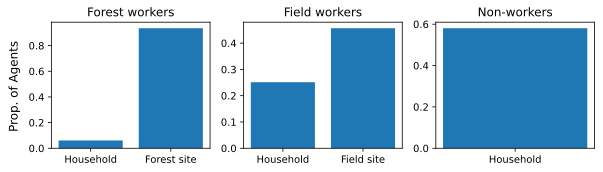

In [24]:
df = pd.DataFrame(data["infection_records"])
inf_loc_counts = df.groupby(by=["worker_type", "activity_id"]).size().reset_index(name="num")

fig, axs = plt.subplots(nrows=1, ncols=3, sharey=False, figsize=(8.5,2.5))

for col, i in zip(axs, range(3)):
    sub_df = inf_loc_counts[inf_loc_counts.worker_type == i]
    # print(np.array(["Household", "Forest site", "Field site"])[sub_df.activity_id], sub_df.count)
    col.bar(np.array(["Household", "Forest site", "Field site"])[sub_df.activity_id], sub_df.num/amts[i])
    
    col.set_title(names[i])

# fig.suptitle("Agent infection locations by risk group")

# fig.supxlabel("Location of infection")
fig.supylabel("Prop. of Agents")
fig.tight_layout()
plt.savefig("img/agent_inf_locations", dpi=330)

## Multiple model runs

In [26]:
num_runs = 10
data = [None] * num_runs

for i in tqdm_notebook(range(num_runs)):
    m = BaselineModel(**NEW_BASELINE_MODEL)
    res, _ = m.run()

    data[i] = res
    data[i]["amts"] = (np.sum([a.forest_worker for a in m.agents]),
                    np.sum([a.field_worker for a in m.agents]),
                    np.sum([not (a.forest_worker or a.field_worker) for a in m.agents]))

  0%|          | 0/10 [00:00<?, ?it/s]

(0.0, 0.2)

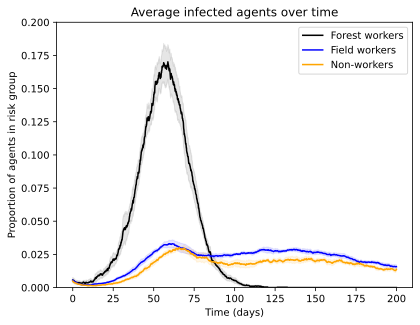

In [29]:
palette = ["black", "blue", "orange", "green"]
names = ["Forest workers", "Field workers", "Non-workers"]
# labels= ["S", "E", "I", "R"]

for j, name, c in zip(range(num_runs), names, palette):
    avgs = np.mean([data[i]["agent_disease_counts"][j][2]/data[i]['amts'][j] for i in range(num_runs)],axis=0)
    plt.plot(data[0]["time"],
             avgs,
             color=c,
            label=name)
    ci = 1.96 * np.std([data[i]["agent_disease_counts"][j][2]/data[i]['amts'][j] for i in range(num_runs)],axis=0)/np.sqrt(num_runs)
    plt.gca().fill_between(data[0]["time"],
                           np.maximum(avgs-ci, 0),
                           (avgs+ci),
                           color=c,
                           alpha=.1)
plt.title("Average infected agents over time")
plt.xlabel("Time (days)")
plt.ylabel("Proportion of agents in risk group")
plt.legend()
plt.savefig("img/avg_infect_agent", dpi=330)
plt.ylim(0,.2)

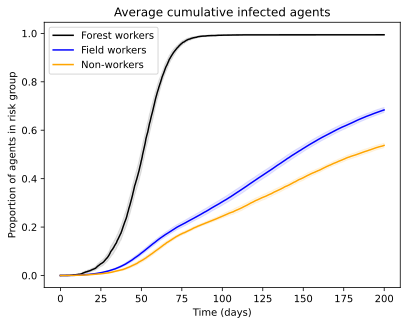

In [28]:
palette = ["black", "blue", "orange", "green"]

for j, name, c in zip(range(num_runs), names, palette):
    sums = np.cumsum([data[i]["agent_infected_unique"][j]/data[i]['amts'][j] for i in range(num_runs)],axis=1)
    avgs = np.mean(sums,axis=0)
    plt.plot(data[0]["time"],
             avgs,
             color=c,
            label=name)
    ci = 1.96 * np.std(sums,axis=0)/np.sqrt(num_runs)
    plt.gca().fill_between(data[0]["time"],
                           np.maximum(avgs-ci, 0),
                           (avgs+ci),
                           color=c,
                           alpha=.1)
plt.title("Average cumulative infected agents")
plt.xlabel("Time (days)")
plt.ylabel("Proportion of agents in risk group")
plt.legend()
plt.savefig("img/avg_cum_infect_agent", dpi=330)

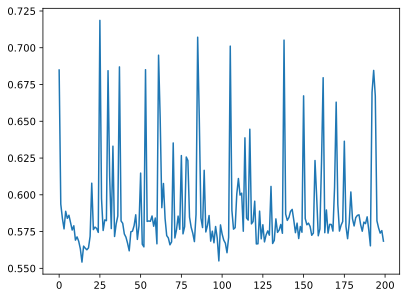

In [53]:
plt.plot(data[0]["used_itn"][np.arange(9,len(data[0]["used_itn"]),12)]/10053)

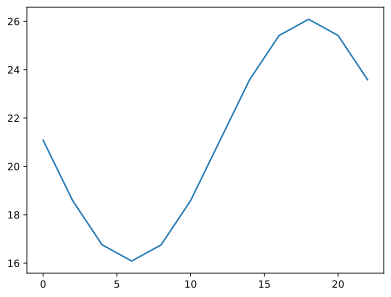

In [60]:
plt.plot(np.arange(0,24,2), data[0]["temperature"][:12])

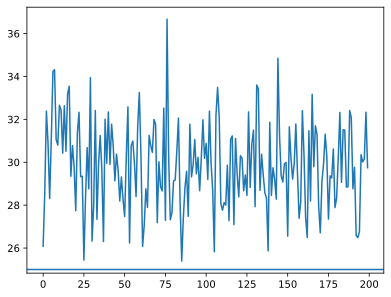

In [56]:
plt.plot(data[0]["temperature"][np.arange(9,len(data[0]["used_itn"]),12)])
plt.axhline(25)

## HBM - formation

### Perceived susceptibility

Derived from prevalence of cases over time, $s_t$:

$$
s_t=\sum_{i=0}^{t}{\delta^i c_{t-i-1}}
$$

where $t$ is the tick of the model (with zero-indexing), $\delta\in[0,1]$ is the time-discounting factor, and $c_t$ is the new cases (infections) at time $t$.

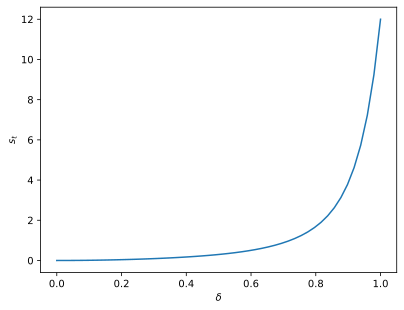

In [6]:
def calculate_s_t(delta, t, c_t_arr):
    return np.sum([(delta**i)*(c_t_arr[t-i-1]) for i in range(0, t)])

t = 24
deltas = np.linspace(0,1,50)

plt.plot(deltas, [calculate_s_t(delta, t, m.c_t) for delta in deltas])
plt.xlabel(r"$\delta$")
plt.ylabel(r"$s_t$")
plt.show()

### Perceived severity

The proportion of an agent's immediate close contacts that have the illness.

<mark>TODO</mark> The right way to implmenet this is to create a `networkx` graph of the agent social network (based on connectivity of households -- agents start in home nodes) and do computation on the fly with this graph.

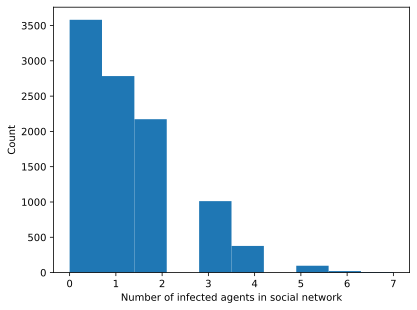

In [7]:
# adj_node_locs = list(m.graph.adj[m.agents[agent_id].node.node_id])
# [[m.agents[j].state==DiseaseState.INFECTED for j in l] for l in [m.nodes[i].agent_ids for i in adj_node_locs]]
# connected_test1 = set([x for l in [m.nodes[i].agent_ids for i in adj_node_locs] for x in l])
plt.hist([np.sum([m.agents[a].state==DiseaseState.INFECTED for a in m.agent_network[agent_id]]) for agent_id in range(m.num_agents)])
plt.xlabel("Number of infected agents in social network")
plt.ylabel("Count")
plt.show()

### Perceived benefits

The number of people who used ITNs last night.

In [9]:
np.sum([a.used_itn_last_night for a in m.agents])/m.num_agents

0.7048642196359296

### Perceived barriers

Need to sample critical temperatures $T_c\sim N(\mu,\sigma)$, then barrier is 'high' if temperature makes an ITN uncomfortable for an agent.

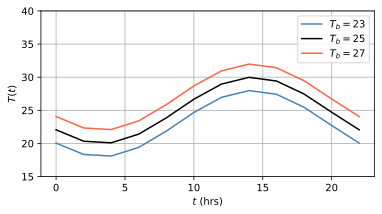

In [75]:
T = lambda t, t_b : t_b + 5*np.sin((np.pi/11)*t - .8*np.pi)
t = np.arange(0,24,2)

plt.figure(figsize=(6,3))

plt.plot(t, T(t, 23),c='steelblue',label=r"$T_b=23$")
plt.plot(t, T(t, 25),c='black',label=r"$T_b=25$")
plt.plot(t, T(t, 27),c='tomato',label=r"$T_b=27$")

plt.ylim(15,40)
plt.grid()
plt.ylabel(r"$T(t)$")
plt.xlabel(r"$t$ (hrs)")
plt.legend()
plt.show()

In [34]:
np.quantile(data['temperature'][np.arange(9,len(data['temperature']),12)],.8)

29.114079282247765

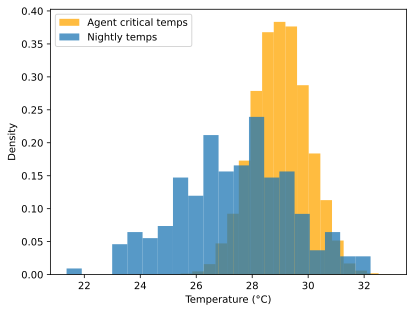

In [35]:
plt.hist(np.random.normal(29,1,size=10_000),bins=20,color='orange',density=True,alpha=.75,label='Agent critical temps')
plt.hist(data['temperature'][np.arange(9,len(data['temperature']),12)],bins=20,density=True,alpha=.75,label='Nightly temps')

plt.ylabel("Density")
plt.xlabel("Temperature (°C)")
plt.legend()
plt.show()